# Introduction to the Parquet File Format

In this tutorial, we will explore some key features and benefits of the Parquet file format that has been developed by Apache to support efficient data storage and retrieval for tabular data. There are various ways of working with this file format (command line tools, APIs in different languages etc.). In this tutorial, we'll work with Parquet files through `pandas`.

### Further Reading:

- [Parquet documentation by Apache](https://parquet.apache.org/docs/)
- [IO Tools in pandas](https://pandas.pydata.org/docs/user_guide/io.html#io-parquet)


## Properties

- Efficient columnar file format
- Homogeneous column types - schema aware
- Storage is optimized:
  - Encoding to reduce redundancies
  - Supports compression
- Designed for fast analytical processing (queries)
  - Split into row groups that store meta data for query processing
  - Files can be further partitioned by columns

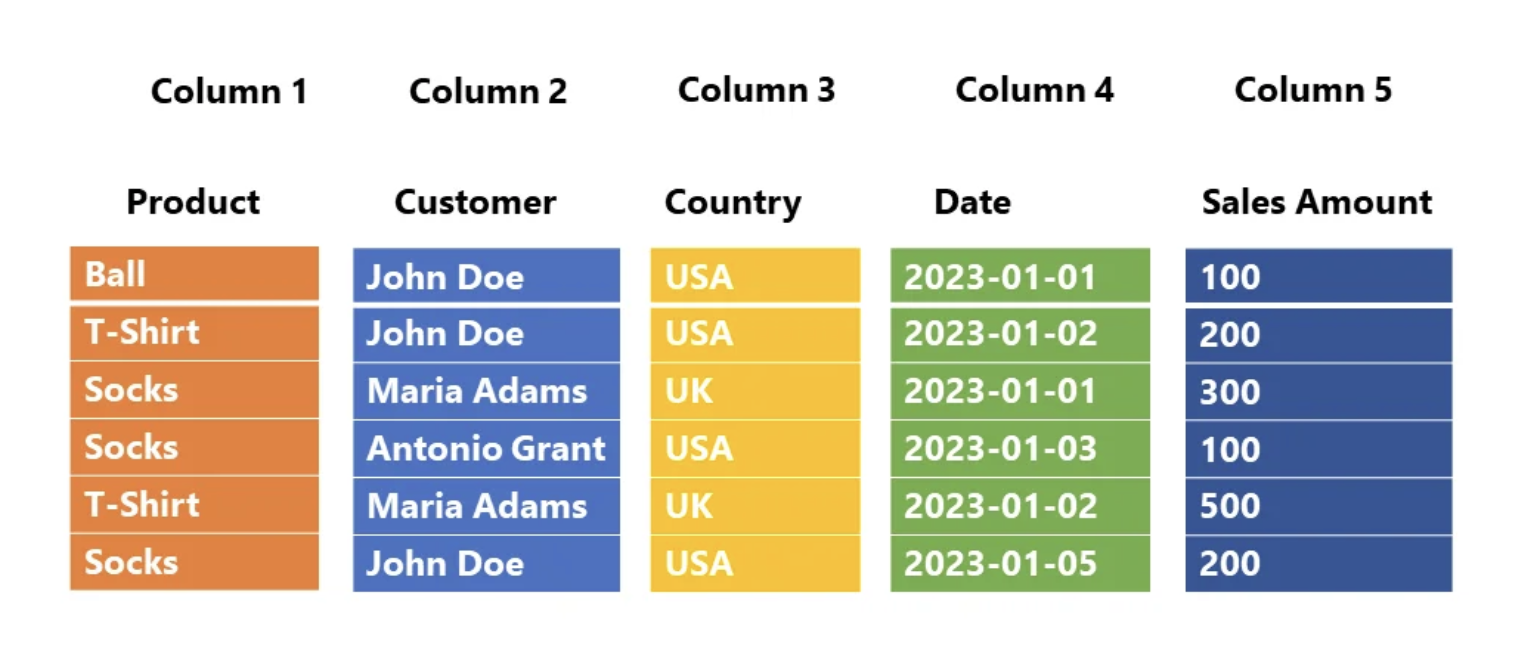

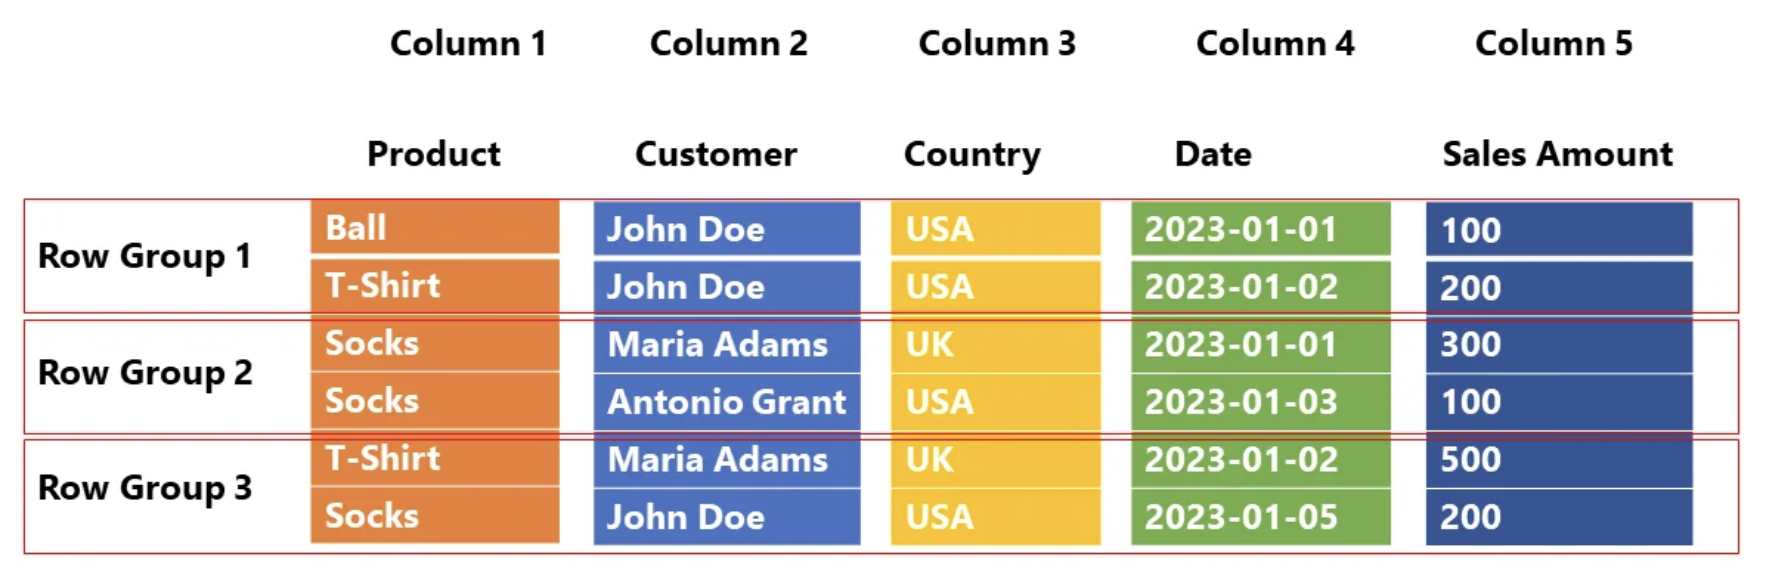

In [2]:
# We'll need pandas and pyarrow for this tutorial. Please install
# them if youe environment doesn't already have these packages.
#
# pandas alone is not enough, we need pyarrow (the default engine) for working with 
# parquet files through pandas.

# Uncomment the following if necessary

#!pip install pandas
#!pip install pyarrow

## Dataset

For demonstration purposes, we'll work with a single CSV file that is relatively clean, and convert it to the parquet format.

Download the CSV file from the following link and store it in storage that is accessible to your Jupyter notebook environment.

[Corporate Energy Consumption | YYC Open Data Portal](https://data.calgary.ca/Environment/Corporate-Energy-Consumption/crbp-innf/about_data)

In [3]:
import pandas as pd

In [5]:
# Inspect size of CSV file
!ls -alh Corporate_Energy_Consumption_20240627.csv

ls: cannot access 'Corporate_Energy_Consumption_20240626.csv': No such file or directory


In [7]:
# Read CSV file to a pandas dataframe
# Time the read so that we can compare with the parquet format later.

%timeit pd.read_csv("Corporate_Energy_Consumption_20240627.csv", header=0, index_col=False, low_memory=False)
df = pd.read_csv("Corporate_Energy_Consumption_20240627.csv", header=0, index_col=False, low_memory=False)

display(df.head())
df.dtypes

687 ms ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Year,Month,Total Consumption,Unit
0,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Apr,1107,Kwh
1,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Aug,1130,Kwh
2,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Dec,1775,Kwh
3,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Feb,2320,Kwh
4,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Jan,1883,Kwh


Business Unit Desc    object
FacilityName          object
Site ID               object
FacilityAddress       object
Energy Description    object
Year                   int64
Month                 object
Total Consumption      int64
Unit                  object
dtype: object

In [8]:
# Inspect memory usage
# How does in-memory sotrage compare to storage on disk?

mdf = df.memory_usage(index=False, deep=True)
display(mdf)

print(f"Total memory usage in MB: {mdf.sum() / (1024*1024)}" ) 

Business Unit Desc    25269088
FacilityName          28875390
Site ID               24670246
FacilityAddress       25920450
Energy Description    23943067
Year                   2817256
Month                 21129420
Total Consumption      2817256
Unit                  20919198
dtype: int64

Total memory usage in MB: 168.19130992889404


In [9]:
# Conversion to parquet from an in-memory pandas dataframe
# is straightforward. 
# The converted file can be uncompressed or compressed.

df.to_parquet('CEC.parquet', compression=None)
df.to_parquet('CEC.parquet.gzip', compression='gzip')

In [10]:
# Let's inspect space utilization on disk and compare
# CSV with parquet.
!ls -alh

total 39M
drwxr-sr-x 3 jovyan users 4.0K Jul  3 01:11  .
drwxr-sr-x 4 jovyan users 4.0K Jul  3 01:05  ..
-rw-r--r-- 1 jovyan users 1.5M Jul  3 01:11  CEC.parquet
-rw-r--r-- 1 jovyan users 624K Jul  3 01:11  CEC.parquet.gzip
-rw-r--r-- 1 jovyan users  34M Jul  3 01:10  Corporate_Energy_Consumption_20240627.csv
-rw-r--r-- 1 jovyan users 720K Jul  3 01:07 'Data Ingestion via APIs.ipynb'
-rw-r--r-- 1 jovyan users 1.6M Jul  3 01:10 'Intro to Parquet.ipynb'
drwxr-sr-x 2 jovyan users 4.0K Jul  3 01:08  .ipynb_checkpoints


In [24]:
# Read it back, time read operation 
# Is the schema preserved?

%timeit pd.read_parquet('CEC.parquet')

pdf = pd.read_parquet('CEC.parquet')
display(pdf.head())
pdf.dtypes

25.5 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Year,Month,Total Consumption,Unit
0,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Apr,1107,Kwh
1,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Aug,1130,Kwh
2,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Dec,1775,Kwh
3,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Feb,2320,Kwh
4,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Jan,1883,Kwh


Business Unit Desc    object
FacilityName          object
Site ID               object
FacilityAddress       object
Energy Description    object
Year                   int64
Month                 object
Total Consumption      int64
Unit                  object
dtype: object

In [11]:
# Inspect memory usage. 
# Does it expand to the same size in a pandas dataframe as the CSV format?
mpdf = pdf.memory_usage(index=False, deep=True)
display(mpdf)

print(f"Total memory usage in MB: {mpdf.sum() / (1024*1024)}" ) 

NameError: name 'pdf' is not defined

In [12]:
# Partitioned Parquet

# We can partition a parquet file on one or more columns. 
# This can faciliate read operations when we only want a subset of the data
# based on the column(s). 
# Also facilitates distributed storage as well as processing via distributed
# memory systems. 

# We'll partition based on Year.
# Can also partition based on Year and Month.
# Partitioned files written in a hierarchical folder structure.
# The parent directory is specified via the path parameter.
df.to_parquet(path='part_data', partition_cols= ['Year'], compression=None)

In [13]:
# Inspect the partitioning.
!ls -alh part_data

total 52K
drwxr-sr-x 13 jovyan users 4.0K Jul  3 01:12  .
drwxr-sr-x  4 jovyan users 4.0K Jul  3 01:12  ..
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2014'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2015'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2016'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2017'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2018'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2019'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2020'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2021'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2022'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2023'
drwxr-sr-x  2 jovyan users 4.0K Jul  3 01:12 'Year=2024'


In [14]:
# We can now read the entire data by specifying the parent directory...
display(pd.read_parquet('part_data/').tail())

# ...or a particular partition
# Notice that the whole table has a YEAR column but the
# individual partitions do not.
display(pd.read_parquet('part_data/Year=2023').head())

,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit,Year
352152,Water Services,WATER VALVE CHAMBER (CITY) - D-32835845 - AIRD...,0040001856704,"10087 TOWNSHIP RD 262, ROCKY VIEW COUNTY",Electricity,Jan,4913,Kwh,2024
352153,Water Services,WATER VALVE CHAMBER (CITY) - D-32835845 - AIRD...,0040001856704,"10087 TOWNSHIP RD 262, ROCKY VIEW COUNTY",Electricity,Mar,4613,Kwh,2024
352154,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Feb,2030,Kwh,2024
352155,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Jan,2893,Kwh,2024
352156,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Mar,2166,Kwh,2024


,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit
0,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Apr,371,Kwh
1,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Aug,348,Kwh
2,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Dec,659,Kwh
3,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Feb,517,Kwh
4,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Jan,612,Kwh


In [29]:
# Filter pushdown
# We can apply filters while reading to read only relevant data.
# No need to first read the entire data and then apply filters.

result = pd.read_parquet('part_data/', filters=[('Year','>=', 2020), ('Year','<=', 2023)])
display(result.head())
display(result.tail())

,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit,Year
0,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Apr,482,Kwh,2020
1,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Aug,390,Kwh,2020
2,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Dec,638,Kwh,2020
3,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Feb,470,Kwh,2020
4,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,Jan,688,Kwh,2020


,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit,Year
794287,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Mar,2672,Kwh,2023
794288,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,May,410,Kwh,2023
794289,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Nov,1357,Kwh,2023
794290,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Oct,1145,Kwh,2023
794291,Water Services,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Sep,540,Kwh,2023


In [30]:
# Can also filter on non-partitioned columns

result = pd.read_parquet('part_data/', filters=[('Total Consumption','>=', 10000), ('Year','==', 2023)])
result.head()

,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit,Year
0,Calgary Transit,304 - MAX YELLOW WOODPARK/CITY CENTRE,0020008373883,928 32 AV NE,Electricity,Dec,10318,Kwh,2023
1,Calgary Transit,304 - MAX YELLOW WOODPARK/CITY CENTRE,0020008373883,928 32 AV NE,Electricity,Jan,10694,Kwh,2023
2,Calgary Transit,306 - MAX TEAL WESTBROOK/DOUGLAS GLEN,0020006474521,928 32 AV NE,Electricity,Dec,11951,Kwh,2023
3,Calgary Transit,306 - MAX TEAL WESTBROOK/DOUGLAS GLEN,0020006474521,928 32 AV NE,Electricity,Feb,11583,Kwh,2023
4,Calgary Transit,306 - MAX TEAL WESTBROOK/DOUGLAS GLEN,0020006474521,928 32 AV NE,Electricity,Jan,13740,Kwh,2023


## Things to Try

- Partition on multiple columns
- Produce interactive visualizations that show data of interest (e.g. data for a particular year). Compare the following two approaches in terms of performance:
  1. Filter the entire in-memory dataframe to get the data that is to be visualized.
  2. Get the relevant data by applying a filter when reading from parquet.